# Notebook to plot and fit SolO EPD SEE data
#### General information about the notebook:
This Notebook allows the user to load, plot and fit SolO EPD SEE energy data.
The data loading process is done by using solo-epd-loader. 
<br>This package can be installed simply by running   %pip install git+https://github.com/jgieseler/solo-epd-loader    in any cell of the notebook. Note that this should only be done once. The package can be updated by running: %pip install git+https://github.com/jgieseler/solo-epd-loader --upgrade
<br>The data will be saved as cdf files to a local folder provided by the user. The data is then used to create dataframes of the electron data for each instrument and energy channel. The data will be plotted as a timeseries.  An energy peak value will be provided for each energy channel using the approximate injection time and following the volocity dispersion. These energy peak values will be plottet as a function of intensity.
The user can choose multiple time avarage values for the data as well as the looking direction for EPT and HET. The peak energy spectra will then be fit using multiple different functions etc etc

In [1]:
from epd_plot_shift import *
from run_the_fit import *


#### Choose a folder where you wish to save the data from the loading, plotting and fitting process. 
A new folder will be created for each separate event if specified by the user. 
<br>The parameters from the fitting process will be saved into csv files and stored into a separate folder. 
<br>These files can be combined by using the '''''' function. 

In [2]:
path_to_folder = r'/home/annafed/Documents/test_folder/'
#create_sub_folders = False

### Parameters for plotting the data, saving the files and making the new folders
Do not change the folder. This will be used to create folders for new events. If the path is changed, the functions will create unnecessary copies of the data.

In [3]:
date = '2021-05-22-2131' #will use this to create new folders

Start date and end date of the event. Different if the event happens close to midnight. Format: yyyymmdd

In [4]:
start_date = int(date[:10].replace('-', ''))
end_date = 20210523

In [5]:
position = posintion_and_traveltime(date[:10])

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
-------------------------------------------  -----  --------
Distance of SolO from the Sun                [AU]    0.95
Length of the Parker Spiral for 400 km/s sw  [AU]    1.08837
Travel time of 4 KeV electrons               [min]  72.7651
Travel time of 10 MeV electrons              [min]   9.06239
Travel time of light                         [min]   7.90091
-------------------------------------------  -----  --------


#### Input parameters for a plot:
plot start and end format 'YYYY-MM-DD-HHmm'

In [6]:
plot_start = '2021-05-22-1800' 
plot_end = '2021-05-23-0100'

<br> Backgroud window: 
<br>Default values: bg_start= None, bg_end = None, bg_distance_from_window = None, bg_period = None
<br> You can either specify a time period by using the same format as for plot_start and plot_end for bg_start and bg_end
<br>If you specify bg_start and bg_end set bg_distance_from_window and bg_period to None
<br>For a moving background window set bg_start and bg_end to None and specify bg_distance_from_window and bg_period
bg_distance_from_window is the distance of the background window start time from the peak window
the input for bg_distance_from_window is in minutes
<br>bg_period is the length of the bg in minutes
<br>by specifying bg_distance_from_window and bg_period the bg will follow the first slope of the peak window

In [7]:
bg_start = None #'2021-10-09-0400' 
bg_end = None #'2021-10-09-0500'
bg_distance_from_window = 120
bg_period = 60

injection time Format: yyyy-mm-dd-hhmm


In [8]:
# Need to subtract the light travel time at SolO distance because the Raul inj. times
# in the STIX/EPD table are shifted from sun to SolO and I need inj. time at the Sun
t_inj = '2021-05-22-2131'


<br>For a fixed non sliding window input travel_distance = 0, 
<br>travel_distance_second_slope = None, fixed_window = period in minutes
<br>For a fixed sliding window input travel_distance = distance in AU,
<br>travel_distance_second_slope = None, fixed_window = period in minutes
<br>for two slopes input travel_distance = distance in AU, 
<br>travel_distance_second_slope = distance 2 in AU, fixed_window = None

In [9]:
travel_distance = position[0][2]
travel_distance_second_slope = None
fixed_window = 60 #either input time period in minutes or None
frac_nan_threshold = 0.9  # exclude all spectrum values with fraction of non-nan data points in search period lower than this

The averaging should be a list

In [10]:
# Averaging. 'mean' = rolling mean, 'none' = no averaging.
averaging_mode = 'mean'
averaging = [2]

In [11]:
# Toggle saving of the images and .csv -files.
saving = True
autodownload_data = True

#direction not in filenames need to fix that
direction = ['sun']
data_type = 'l2'

## Plots

In [12]:
df_particles_step, energies_step = epd_load(sensor = 'step', level = 'l2', startdate = start_date, 
                                                enddate=end_date,  path=path_to_folder, autodownload=True, 
                                                only_averages = True)


Creating dir /home/annafed/Documents/test_folder/l2/epd/step/


OSError: [Errno 45] Operation not supported: '/home/annafed'

## STEP

/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/epd_plot_shift.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_electron_fluxes[df_electron_fluxes<0] = np.NaN
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/epd_plot_shift.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_electron_fluxes[df_electron_fluxes<0] = np.NaN
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/epd_plot_shift.py:518: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...)

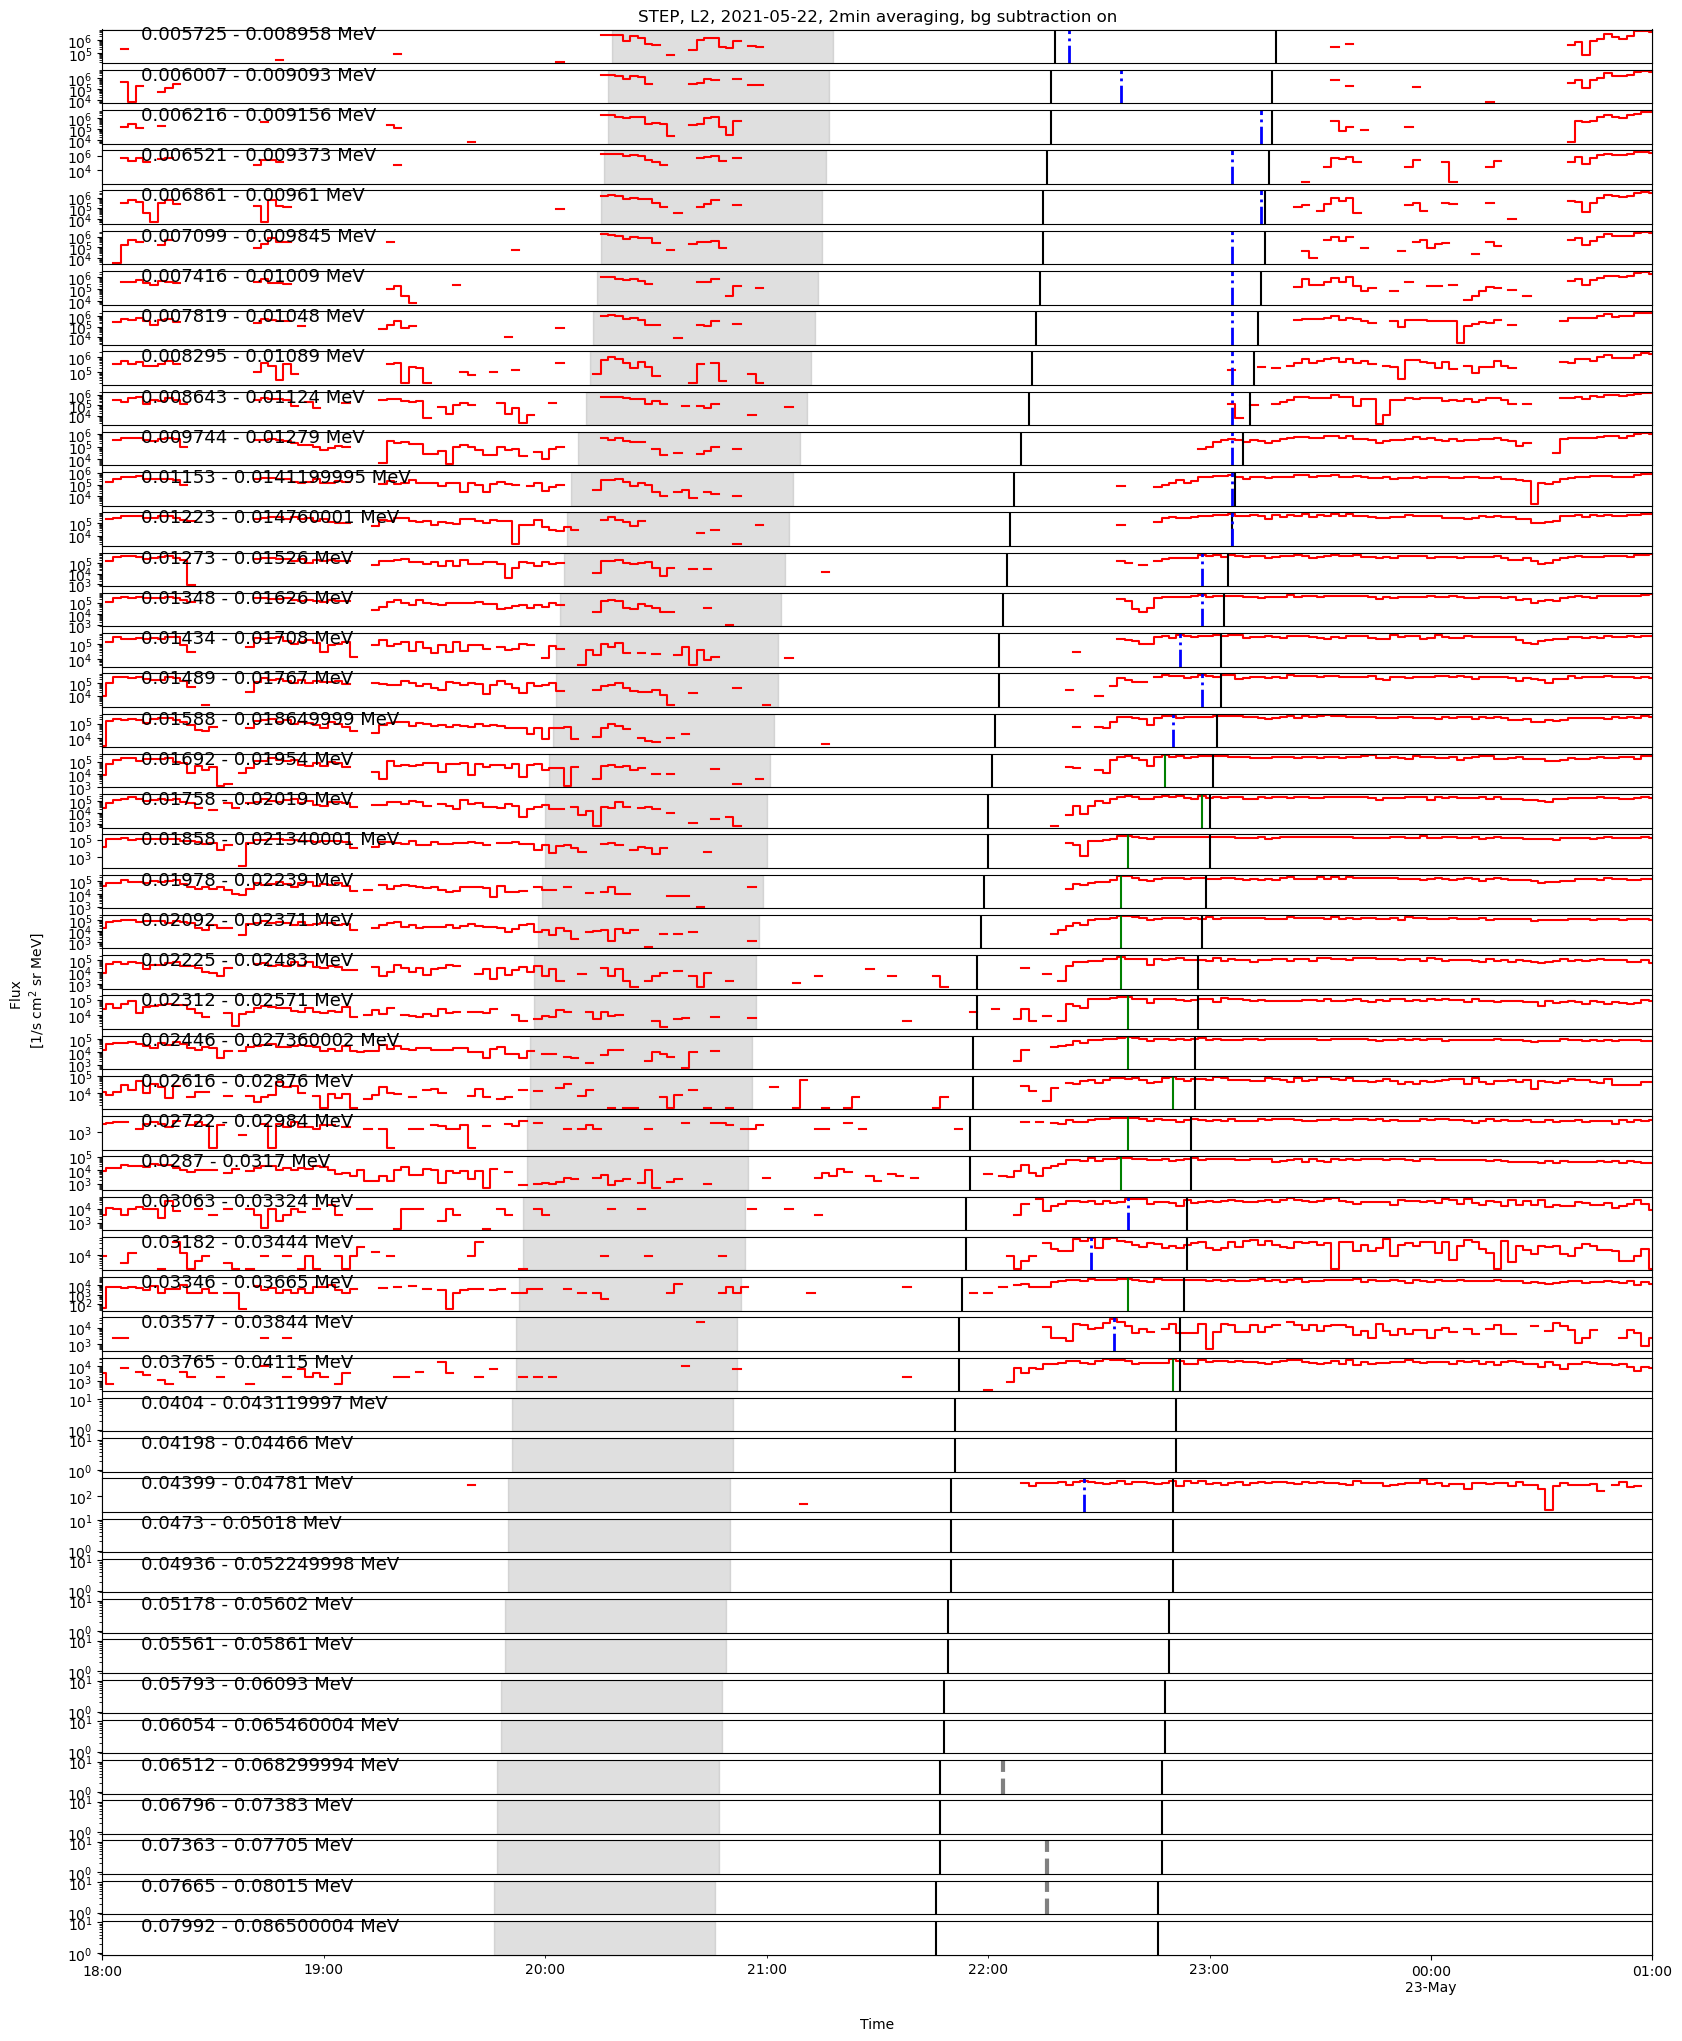

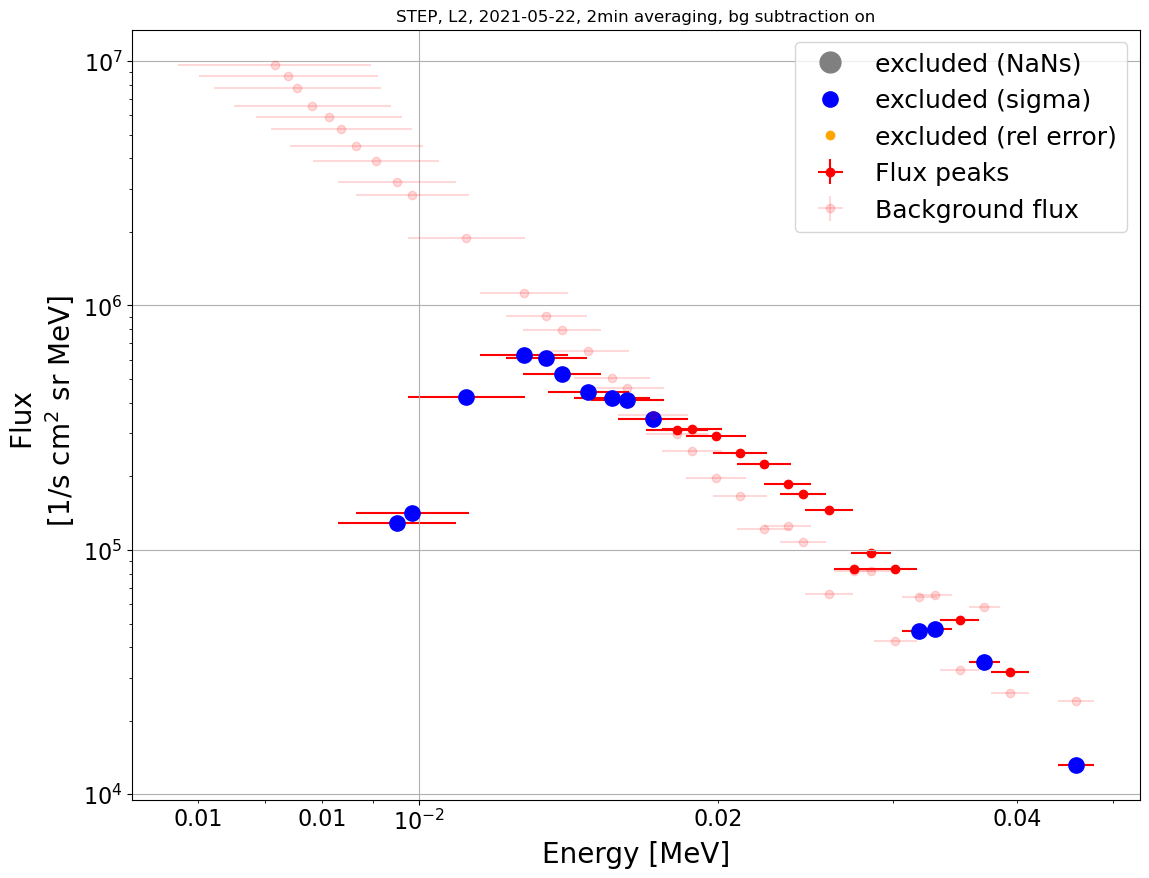

In [13]:
for av in averaging:
    data_step = extract_electron_data(df_particles_step, energies_step, plot_start, plot_end, t_inj, 
                                      bgstart = bg_start , bgend = bg_end, bg_distance_from_window = bg_distance_from_window, 
                                      bg_period = bg_period, travel_distance = travel_distance, 
                                      travel_distance_second_slope = travel_distance_second_slope, fixed_window = fixed_window, 
                                      instrument = 'step', data_type = 'l2', averaging_mode='mean', averaging=av, 
                                      masking=True)
    
    if saving: write_to_csv(data_step, path=path_to_folder)
    bg_b = True
    plot_channels(data_step, bg_subtraction=bg_b, path=path_to_folder, savefig=saving)
    bg_b = True
    plot_spectrum_peak(data_step, bg_subtraction=bg_b, path=path_to_folder, savefig=saving)


## EPT

/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/epd_plot_shift.py:518: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  timestamp_loc = df_electron_uncertainties['Electron_Uncertainty_{}'.format(channel)].index.get_loc(peak_timestamp, method='nearest')


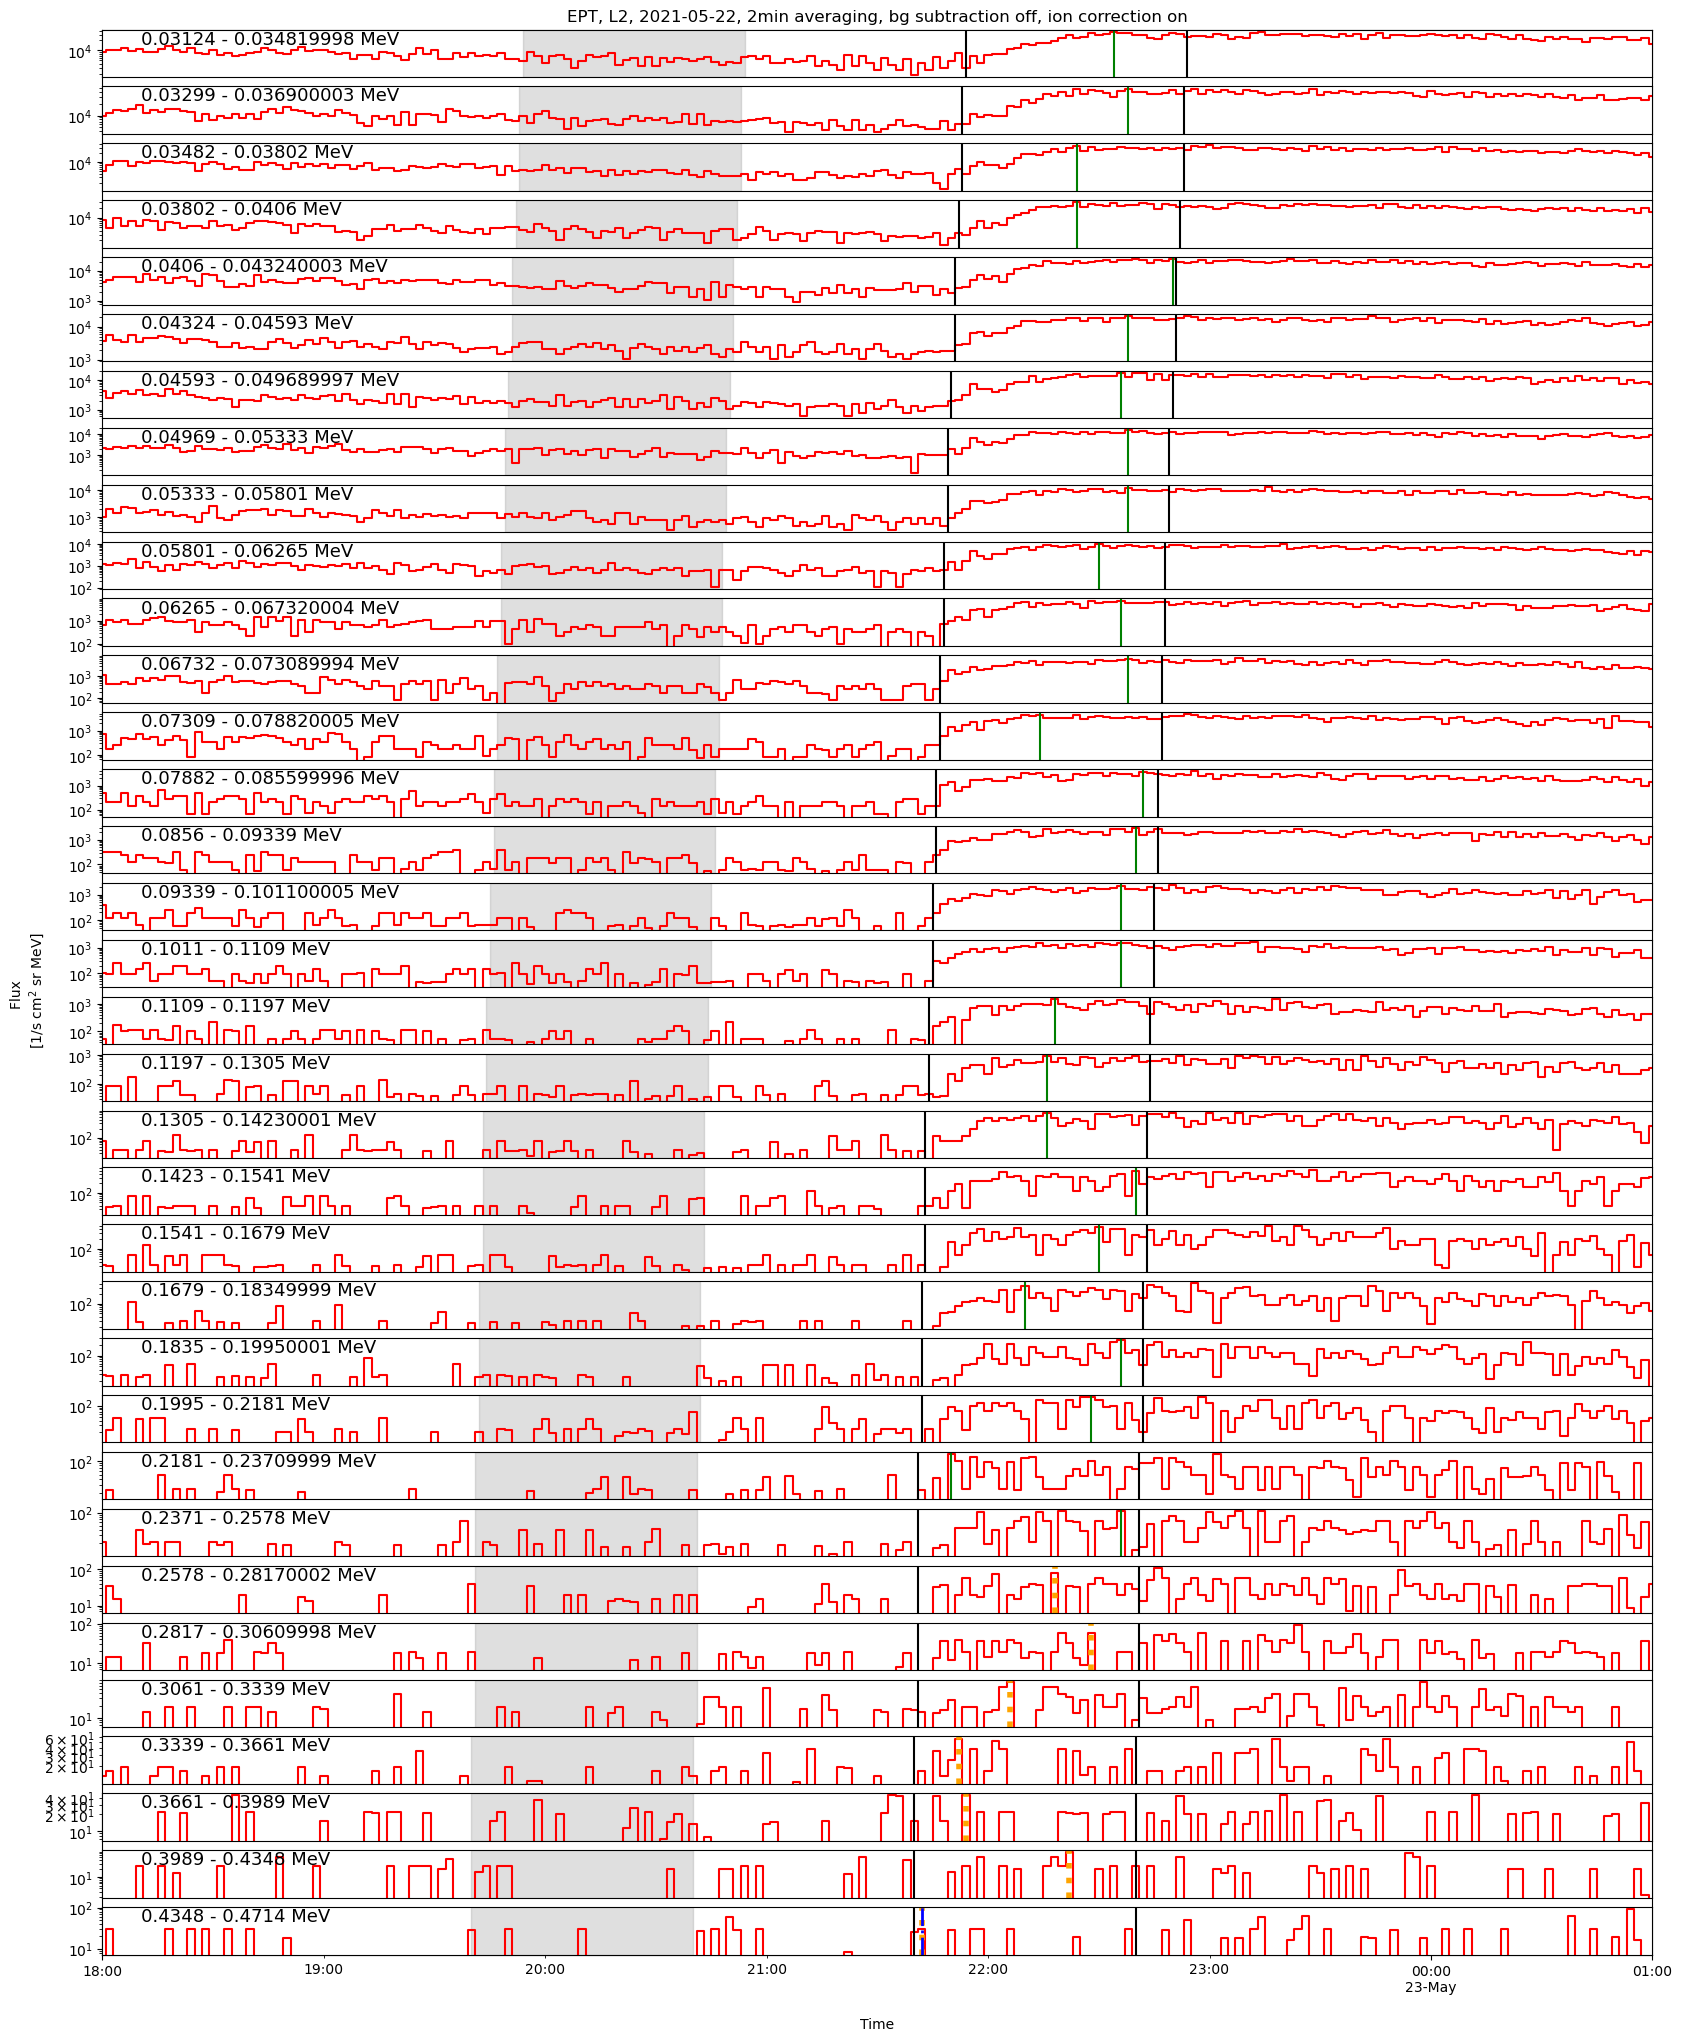

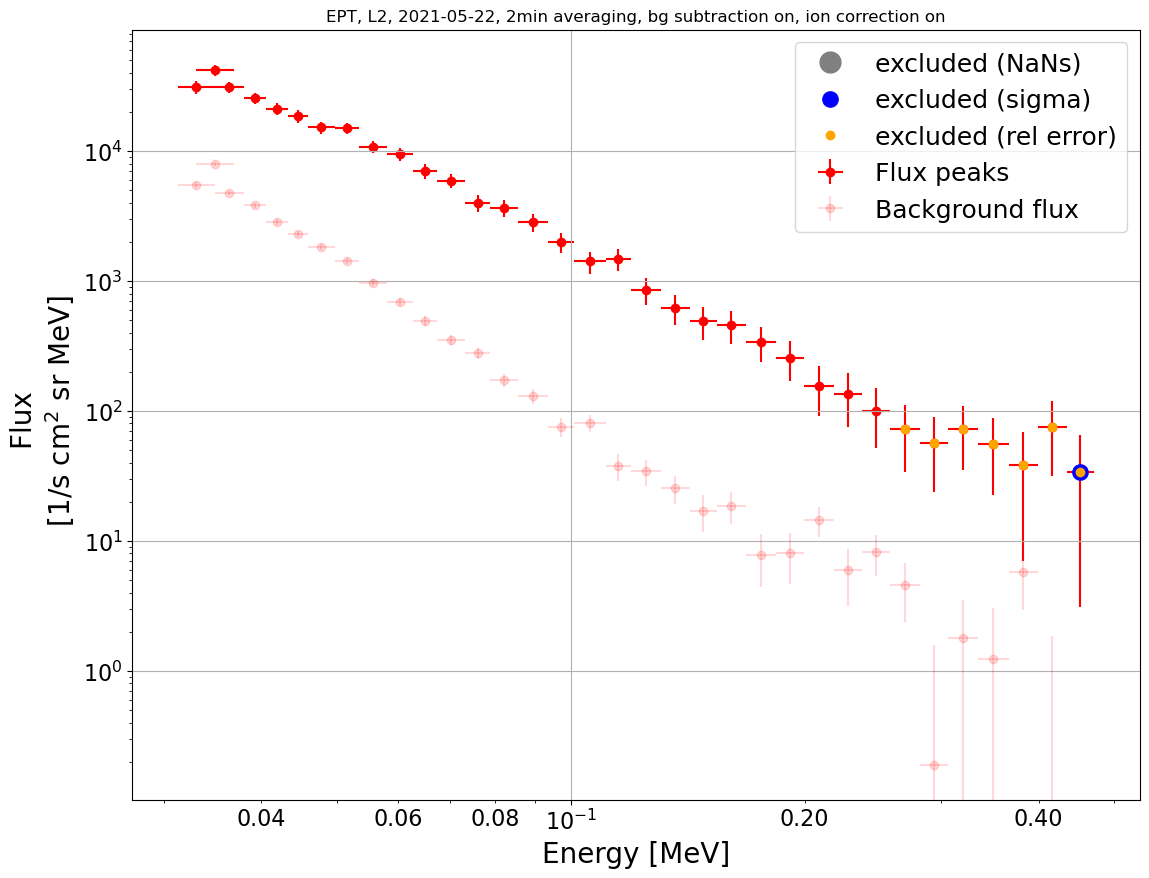

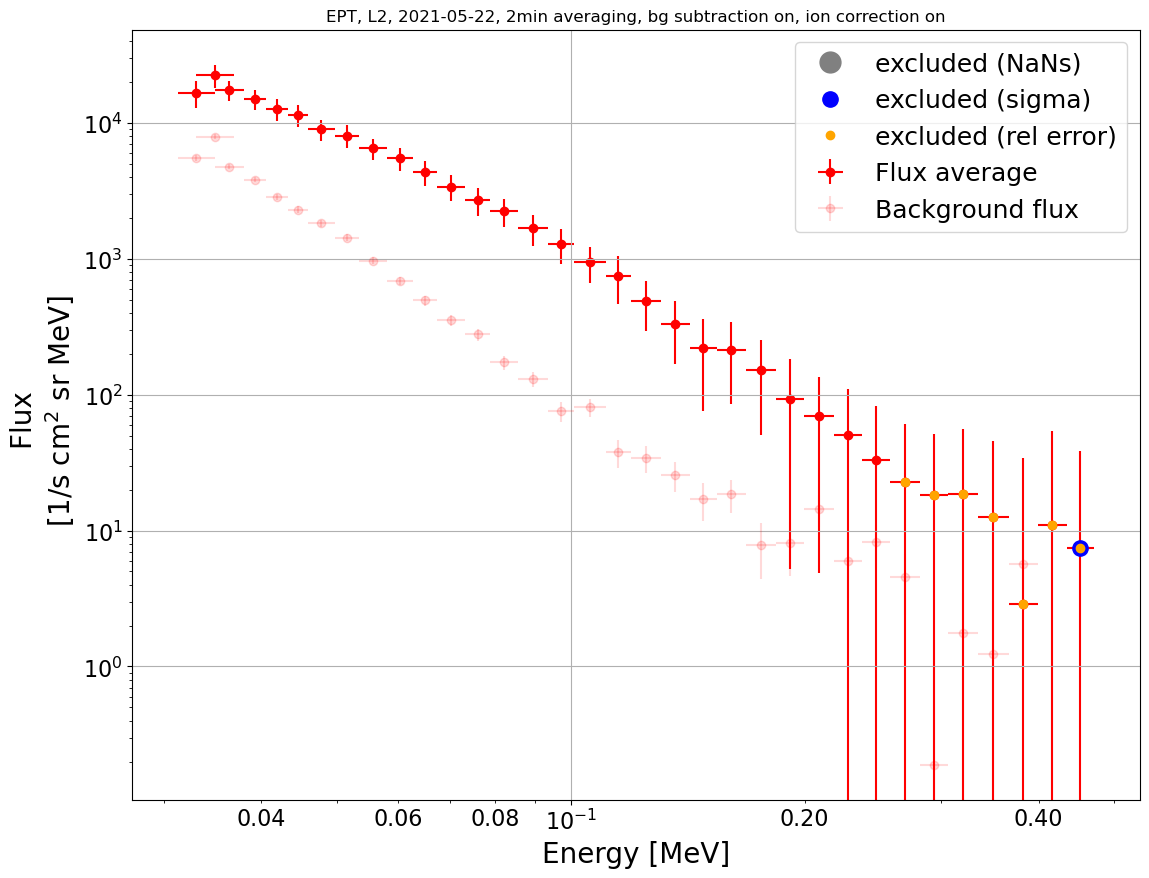

In [14]:
for view in direction:
    df_protons_ept, df_electrons_ept, energies_ept = epd_load(sensor = 'ept', viewing = view, level = 'l2',
                                                                  startdate = start_date, enddate = end_date, 
                                                                  path=path_to_folder, autodownload=True)
    for av in averaging:
    #for ion_b in [False, True]:
        ion_b = True    
        data_ept = extract_electron_data(df_electrons_ept, energies_ept, plot_start, plot_end, t_inj, bgstart = bg_start, 
                                         bgend = bg_end, bg_distance_from_window = bg_distance_from_window, bg_period = bg_period, 
                                         travel_distance = travel_distance, travel_distance_second_slope=travel_distance_second_slope, 
                                         fixed_window=fixed_window, instrument = 'ept', data_type = 'l2', 
                                         averaging_mode=averaging_mode, averaging=av, masking=True, 
                                         ion_conta_corr=ion_b, df_protons = df_protons_ept)
        
        if saving: write_to_csv(data_ept, path=path_to_folder)
        bg_b = False
        plot_channels(data_ept, bg_subtraction=bg_b, path=path_to_folder, savefig=saving, frac_nan_threshold=frac_nan_threshold, rel_err_threshold=0.5)
        bg_b = True
        plot_spectrum_peak(data_ept, bg_subtraction=bg_b, path=path_to_folder, savefig=saving, frac_nan_threshold=frac_nan_threshold) 
        plot_spectrum_average(data_ept, bg_subtraction=bg_b, path=path_to_folder, savefig=saving, frac_nan_threshold=frac_nan_threshold)      
        

## HET

/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/epd_plot_shift.py:518: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  timestamp_loc = df_electron_uncertainties['Electron_Uncertainty_{}'.format(channel)].index.get_loc(peak_timestamp, method='nearest')


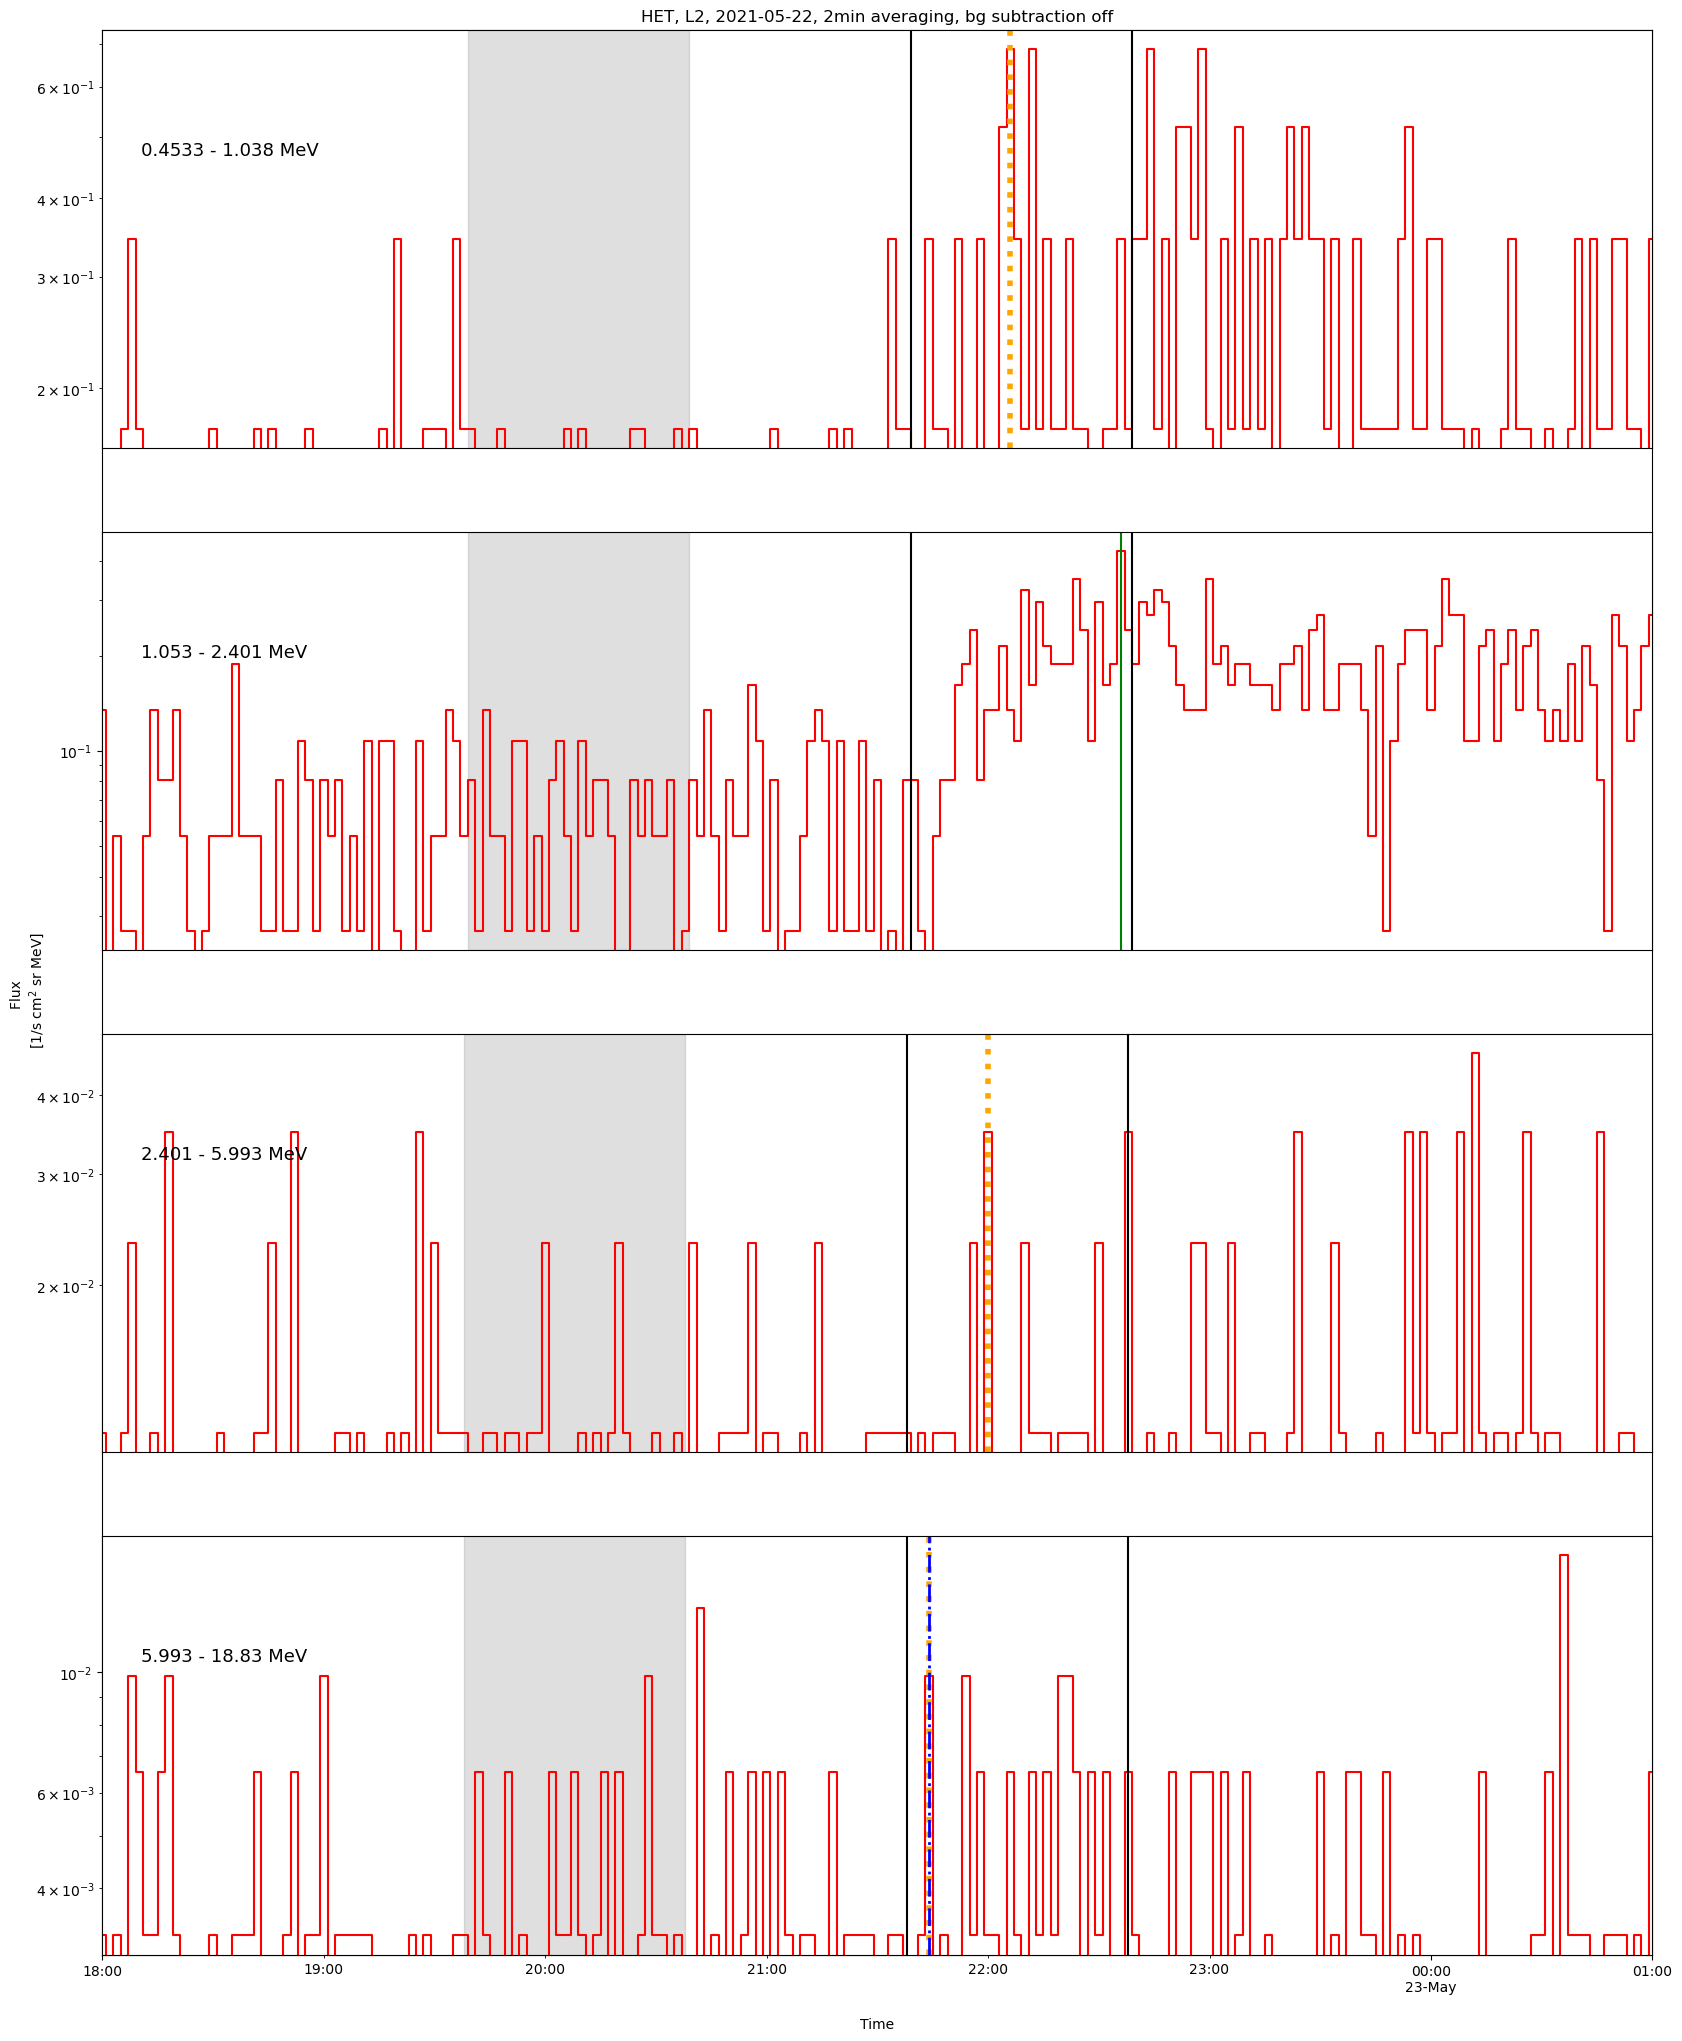

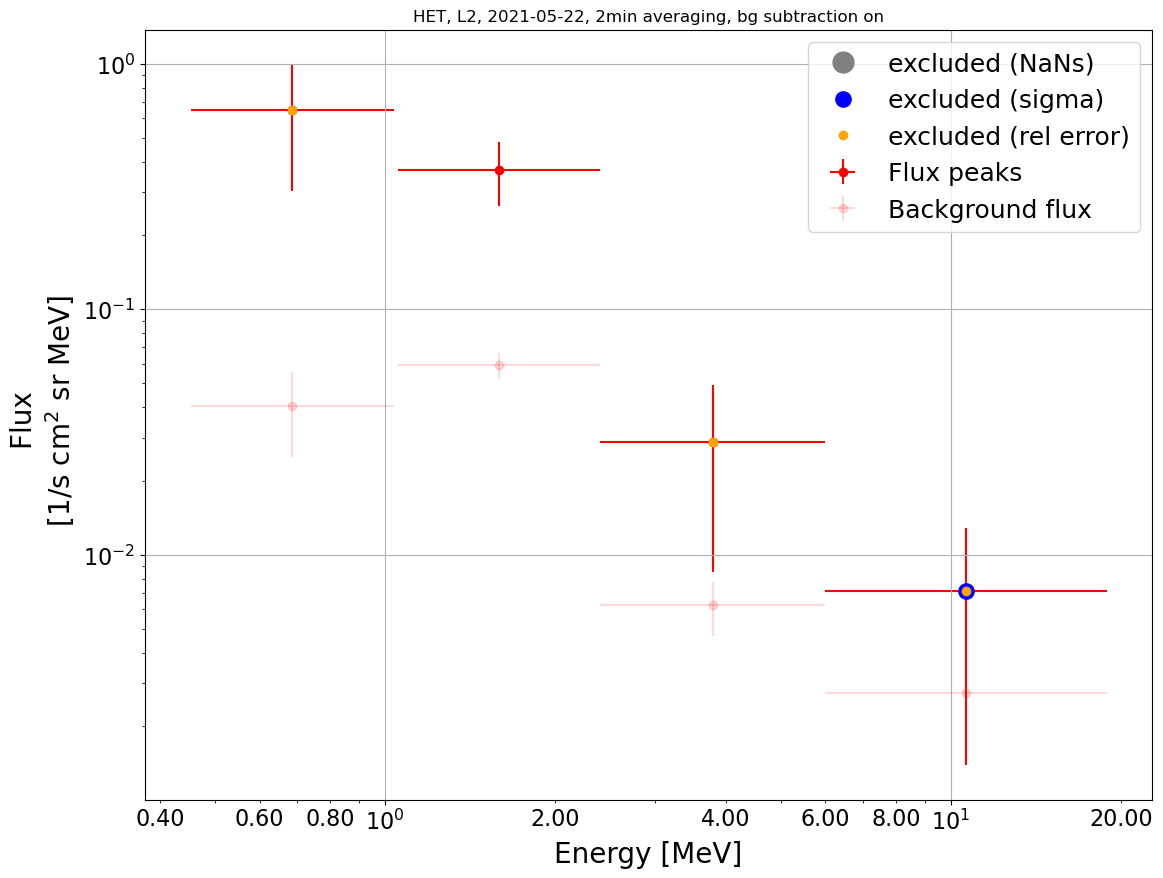

In [15]:
for view in direction:
    df_protons_het, df_electrons_het, energies_het = epd_load(sensor = 'het', viewing = view, level = 'l2',
                                                            startdate = start_date, enddate = end_date, 
                                                            path=path_to_folder, autodownload=True)
    for av in averaging:
        data_het = extract_electron_data(df_electrons_het, energies_het, plot_start, plot_end, t_inj, 
                                         bgstart = bg_start, bgend = bg_end,  bg_distance_from_window = bg_distance_from_window,
                                         bg_period = bg_period, travel_distance = travel_distance, 
                                         travel_distance_second_slope = travel_distance_second_slope, 
                                         fixed_window = fixed_window, instrument='het', data_type='l2', 
                                         averaging_mode=averaging_mode, averaging=av, df_protons = df_protons_het)
        
        if saving: write_to_csv(data_het, path=path_to_folder)
    #for bg_b in [False, True]:
        bg_b = False    
        plot_channels(data_het, bg_subtraction=bg_b, path=path_to_folder, savefig=saving)
        bg_b = True
        plot_spectrum_peak(data_het, bg_subtraction=bg_b, path=path_to_folder, savefig=saving)
        

## FITTING THE DATA
In this section, the prvioustly plotted peak spectrum data will be fitted using various functions. etc etc


In [16]:
sigma = 3
rel_err = 0.5
frac_nan_threshold = 0.9
leave_out_1st_het_chan = True
shift_step_data = False
shift_factor = None #0.8

/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/my_power_law_fits_odr.py:43: RuntimeWarning: invalid value encountered in double_scalars
  y = c1 * (x/0.1)**gamma1  * ((x**alpha + E_break**alpha)/(0.1**alpha+E_break**alpha))**((gamma2-gamma1)/alpha)
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/my_power_law_fits_odr.py:43: RuntimeWarning: invalid value encountered in power
  y = c1 * (x/0.1)**gamma1  * ((x**alpha + E_break**alpha)/(0.1**alpha+E_break**alpha))**((gamma2-gamma1)/alpha)
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/my_power_law_fits_odr.py:43: RuntimeWarning: overflow encountered in double_scalars
  y = c1 * (x/0.1)**gamma1  * ((x**alpha + E_break**alpha)/(0.1**alpha+E_break**alpha))**((gamma2-gamma1)/alpha)
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/my_power_law_fits_odr.py:43: RuntimeWarning: invalid value encountered in divide
  y = c1 * (x/0.1)**gamma1  * ((x**alpha + E_break**alpha)/(0.1**alpha+E_break**alpha))**((gamma2-gamma1)/alpha

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
76.03080275958428


/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/my_power_law_fits_odr.py:111: RuntimeWarning: divide by zero encountered in power
  y = c1*(x/0.1)**gamma1 * ((x**alpha + E_break**alpha)/(0.1**alpha+E_break**alpha))**((gamma2-gamma1)/alpha)*np.exp(-(x/E_cut)**2)
/home/annafed/Documents/GitHub/SolOEPD-Plot-n-Fit-SEE/my_power_law_fits_odr.py:202: RuntimeWarning: invalid value encountered in power
  return c1*x**gamma1


triple


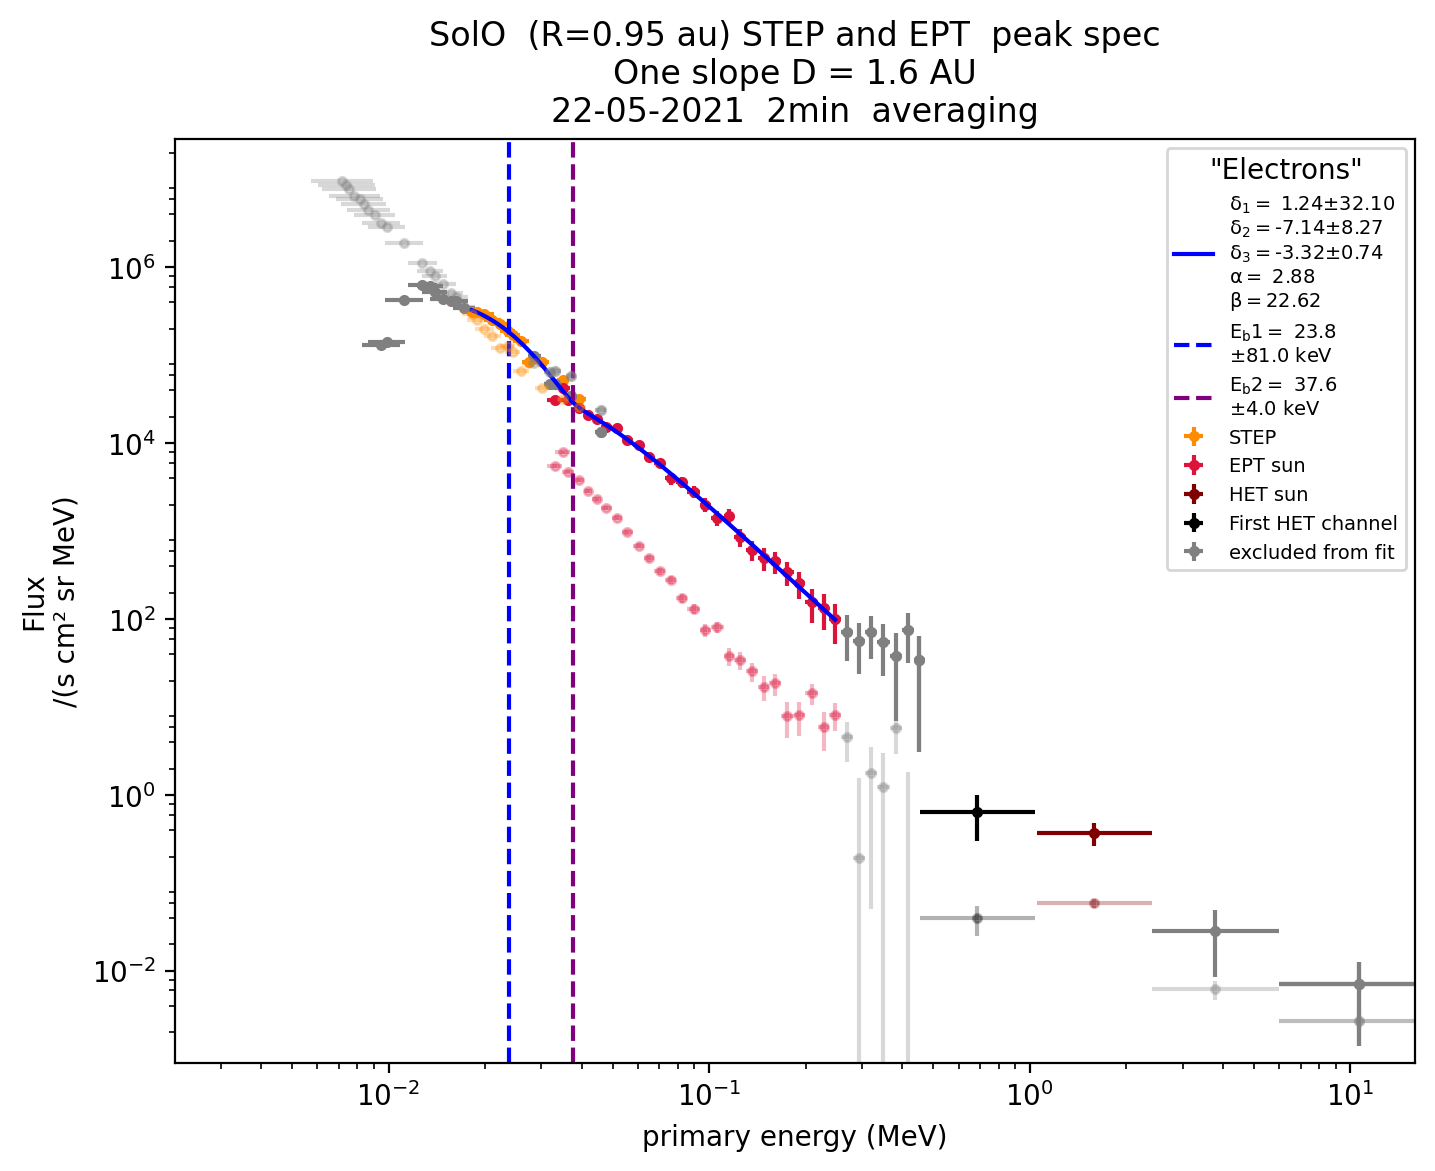

In [17]:
FIT_DATA(path_to_folder, date[:10], averaging = 2, fit_type= 'step_ept', step = True, ept = True, het = True, 
         which_fit = 'triple', sigma = 3, rel_err = 0.5, frac_nan_threshold = 0.9, fit_to = 'peak', slope = None, 
         e_min = None, e_max = None, g1_guess = -1.9, g2_guess = -2.5, g3_guess = -4, c1_guess = 1000, 
         alpha_guess = 10, beta_guess = 10, break_guess_low = 0.6, break_guess_high = 1.2, cut_guess = 1.2, 
         use_random = True, iterations = 20, leave_out_1st_het_chan = True, shift_step_data = False, 
         shift_factor = None, save_fig = True, save_pickle = False, save_fit_variables = True, save_fitrun = True)

